In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  6 13:33:08 2020

@author: aswart
"""

# python 3 version 2/15
import numpy as np
import matplotlib.pyplot as plt

def rk4(x,t,tau,derivsRK):
#%  Runge-Kutta integrator (4th order)
#% Input arguments -
#%   x = current value of dependent variable
#%   t = independent variable (usually time)
#%   tau = step size (usually timestep)
#%   derivsRK = right hand side of the ODE; derivsRK is the
#%             name of the function which returns dx/dt
#%             Calling format derivsRK(x,t).
#% Output arguments -
#%   xout = new value of x after a step of size tau
    half_tau = 0.5*tau
    F1 = derivsRK(x,t)
    t_half = t + half_tau
    xtemp = x + half_tau*F1
    F2 = derivsRK(xtemp,t_half)
    xtemp = x + half_tau*F2
    F3 = derivsRK(xtemp,t_half)
    t_full = t + tau
    xtemp = x + tau*F3
    F4 = derivsRK(xtemp,t_full)
    xout = x + tau/6.*(F1 + F4 + 2.*(F2+F3))
    return xout
def rka(x,t,tau,err,derivsRK):

#% Adaptive Runge-Kutta routine
#% Inputs
#%   x          Current value of the dependent variable
#%   t          Independent variable (usually time)
#%   tau        Step size (usually time step)
#%   err        Desired fractional local truncation error
#%   derivsRK   Right hand side of the ODE; derivsRK is the
#%              name of the function which returns dx/dt
#%              Calling format derivsRK(x,t).
#% Outputs
#%   xSmall     New value of the dependent variable
#%   t          New value of the independent variable
#%   tau        Suggested step size for next call to rka

#%* Set initial variables
    tSave = t;  xSave = x    # Save initial values
    safe1 = .9;  safe2 = 4.  # Safety factors
    eps = np.spacing(1) # smallest value

#%* Loop over maximum number of attempts to satisfy error bound
    maxTry = 100

    for iTry in range(1,maxTry):
	
#%* Take the two small time steps
        half_tau = 0.5 * tau
        xTemp = rk4(xSave,tSave,half_tau,derivsRK)
        t = tSave + half_tau
        xSmall = rk4(xTemp,t,half_tau,derivsRK)
  
  #%* Take the single big time step
        t = tSave + tau
        xBig = rk4(xSave,tSave,tau,derivsRK)
  
  #%* Compute the estimated truncation error
        scale = err * (np.abs(xSmall) + np.abs(xBig))/2.
        xDiff = xSmall - xBig
        errorRatio = np.max( [np.abs(xDiff)/(scale + eps)] )
        
        #print safe1,tau,errorRatio
  
  #%* Estimate news tau value (including safety factors)
        tau_old = tau

        tau = safe1*tau_old*errorRatio**(-0.20)
        tau = np.max([tau,tau_old/safe2])
        tau = np.min([tau,safe2*tau_old])
  
  #%* If error is acceptable, return computed values
        if errorRatio < 1 : 
          # xSmall = xSmall #% +  (xDiff)/15
          #   xSmall = (16.*xSmall - xBig)/15. # correction
            return xSmall, t, tau  

#%* Issue error message if error bound never satisfied
    print ('ERROR: Adaptive Runge-Kutta routine failed')
    return
def gravrk(s,t):
#%  Returns right-hand side of Kepler ODE; used by Runge-Kutta routines
#%  Inputs
#%    s      State vector [r(1) r(2) v(1) v(2)]
#%    t      Time (not used)
#%  Output
#%    deriv  Derivatives [dr(1)/dt dr(2)/dt dv(1)/dt dv(2)/dt]

#%* Compute acceleration
    r = np.array([s[0], s[1]])  # Unravel the vector s into position and velocity
    v = np.array([s[2] ,s[3]])
    accel = -GM*r/np.linalg.norm(r)**3  # Gravitational acceleration

#%* Return derivatives [dr(1)/dt dr(2)/dt dv(1)/dt dv(2)/dt]
    derivs = np.array([v[0], v[1], accel[0], accel[1]])
    return derivs

# orbit - Program to compute the orbit of a comet.
#clear all;  help orbit;  % Clear memory and print header

def orbit(input_dict = {},calc_info = False, 
          inter_input = False, plot_traj = True, plot_energy = False):
    if inter_input:
        # Set initial position and velocity of the comet.
        r0 = float(input("Enter initial radial distance (AU): "))
        # v0 = float(input("Enter initial tangential velocity (AU/yr): "))
        vstr = str(input("Enter initial tangential velocity (AU/yr) as a number or multiple of Pi (e.g.,2*pi): "))
        
        # modify input to allow 'pi'
        vinp = vstr.split('*')
        if (vinp[-1].lower() == 'pi'):
          v0 = float(vinp[0])*np.pi
        else:
          v0 = float(vinp[0])
        
        nStep = int(input("Enter number of steps: "))
        tau =  float(input("Enter time step (yr): "))
        NumericalMethod=0
        while(NumericalMethod not in np.array([1,2,3,4,5,6,7])):
            NumericalMethod = int(input("Choose a number for a numerical method:\n\
         1-Euler, 2-Euler-Cromer, 3-Runge-Kutta 4-Adaptive R-K: "))
    elif input_dict:
        r0 = input_dict['r0']
        v0 = input_dict['v0']
        nStep = input_dict['nStep']
        tau = input_dict['tau']
        NumericalMethod = input_dict['NumericalMethod']
    else:
        r0 = 1
        v0 = 2*np.pi
        nStep = 15
        tau = .1
        NumericalMethod = 2
    
    r = np.array([r0, 0.])
    v = np.array([0., v0])
    state = np.array([ r[0], r[1], v[0], v[1] ])   # Used by R-K routines
    
    #Set physical parameters (mass, G*M)
    GM = 4*np.pi**2      # Grav. const. * Mass of Sun (au^3/yr^2)
    mass = 1.        # Mass of comet
    adaptErr = 1.e-4 # Error parameter used by adaptive Runge-Kutta
    time = 0.0
    
    #%* Loop over desired number of steps using specified
    #%  numerical method.
    for istep in range(0,nStep):
    
      #%* Record position and energy for plotting.
      # Initially set the arrays for the first step
      if istep == 0:
          rplot = np.linalg.norm(r)
          thplot = np.arctan2(r[1],r[0])
          tplot = time
          kinetic = .5*mass*np.linalg.norm(v)**2
          potential= - GM*mass/np.linalg.norm(r)
          perihelion = []
          aphelion = []
          orbit_end = 0
          
      else:    
          rplot = np.append(rplot,np.linalg.norm(r))           #Record position for polar plot
          thplot = np.append(thplot,np.arctan2(r[1],r[0]))
          tplot = np.append(tplot,time)
          kinetic = np.append(kinetic,0.5*mass*np.linalg.norm(v)**2)   # Record energies
          potential= np.append(potential,- GM*mass/np.linalg.norm(r))
      
      #%* Calculate new position and velocity using desired method.
      if NumericalMethod == 1 :
        accel = -GM*r/np.linalg.norm(r)**3
        r = r + tau*v             # Euler step
        v = v + tau*accel
        time = time + tau
      elif NumericalMethod == 2:
        accel = -GM*r/np.linalg.norm(r)**3
        v = v + tau*accel
        r = r + tau*v             # Euler-Cromer step
        time = time + tau
      elif NumericalMethod == 3:
        state = rk4(state,time,tau,gravrk)
        r = [state[0], state[1]]   # 4th order Runge-Kutta
        v = [state[2], state[3]]
        time = time + tau
      else:
        [state, time, tau] = rka(state,time,tau,adaptErr,gravrk)
        r = [state[0], state[1]]   # Adaptive Runge-Kutta
        v = [state[2], state[3]]
      
            # Find perihelion, aphelion
      if istep >= 2:
          if rplot[istep-1] > rplot[istep-2] and rplot[istep-1] > rplot[istep]:
              #if rplot[istep-1] >= min(rplot)-tau and rplot[istep-1] <= min(rplot)+tau:
              #    perihelion.append( (rplot[istep-1],tplot[istep-1]) )
              if rplot[istep-1] >= max(rplot)-tau and rplot[istep-1] <= max(rplot)+tau:
                  aphelion.append( [rplot[istep-1],thplot[istep-1],tplot[istep-1],istep] )
          elif rplot[istep-1] < rplot[istep-2] and rplot[istep-1] < rplot[istep]:
              perihelion.append( [rplot[istep-1],thplot[istep-1],tplot[istep-1],istep] )  
        
        
      # If sometime after first step and theta goes from neg to pos, then we know we've completed an orbit
      if istep != 0 and (thplot[-2:]*[-1,1] > 0).all():
          orbit_end = istep
      if istep >= orbit_end*1.2 and orbit_end != 0:
          # Just want to compute more than enough of the obit to get accurate perihelion data etc
          break
          
    # Trim data to single orbit
    rplot = rplot[:orbit_end+1]
    thplot = thplot[:orbit_end+1]
    tplot = tplot[:orbit_end+1]
    kinetic = kinetic[:orbit_end+1]
    potential = potential[:orbit_end+1]
    aphelion = np.array(aphelion) # Dont want ot trim peri and aphelion to avoid boundary cond snipping
    perihelion = np.array(perihelion)
    
    if plot_traj:
        #%* Graph the trajectory of the comet.
        plt.figure(1); plt.clf()  #Clear figure 1 window and bring forward
        plt.polar(thplot,rplot,'-')  # Use polar plot for graphing orbit
        plt.xlabel('Distance (AU)')
        plt.grid(True)
    
    if plot_energy:
        #%* Graph the energy of the comet versus time.
        plt.figure(2); plt.clf()   # Clear figure 2 window and bring forward
        totalE = kinetic + potential   # Total energy
        plt.plot(tplot,kinetic,'-.',tplot,potential,'--',tplot,totalE,'-')
        #plt.legend('Kinetic','Potential','Total')
        plt.xlabel('Time (yr)'); plt.ylabel('Energy (M AU^2/yr^2)')
        plt.grid(True)
        plt.show()

    if calc_info:
        
        # Theoretical major axis eq 7
        a_t = 1/( (2/r0) - (v0**2/GM) )
        # Find theoretical period from eq 10
        T_t = a_t**(3/2)
        E_t = -(GM*mass/2*a_t) # Thry Energy
        L_t = r0*mass*v0 #Thry angular momentum
        # Period
        T = tplot[-2]
        print("Numerical Period:",T)
        print('Theoretical Period:',T_t)
        
        # Part b
        # semi-major axis same as in hw3_ex14
        a = (aphelion[0,0]+perihelion[0,0])/2
        print("\nNumerical Semi-major axis:",a)
        print("Theory Semi-major axis (calc with Kepler's 3rd law, using numerical period'):",a_t)
        print("The similarity in computed vs. theory confirms Kepler's 3rd law (in this case)")
        
        # eccentricity Part a
        e = rplot[int(aphelion[0,-1])]/a - 1
        
        
        e_t = np.sqrt(1 + ( (2*E_t*L_t**2) / (GM**2*mass**3) ) )
        print("\nNumerical eccentricity:",e)
        print("Theoretical eccentricity:",e_t)
        # perihelion distance
        print("\nNumerical Perihelion Distance:",perihelion[0,0])
        
        # Virial theorem Part c
        print("-----\nPart c")
        time_avg_kin = np.mean(kinetic)
        time_avg_pot = np.mean(potential)
        print("time average kinetic energy:",time_avg_kin)
        print("- (1/2) * time average potential energy:",-.5*time_avg_pot)

        return rplot,thplot,aphelion,perihelion,kinetic,potential

    return rplot, thplot
    

non-elliptical
Numerical Period: 1.0000000000000007
Theoretical Period: 1.0

Numerical Semi-major axis: 1.000019739545717
Theory Semi-major axis (calc with Kepler's 3rd law, using numerical period'): 1.0
The similarity in computed vs. theory confirms Kepler's 3rd law (in this case)

Numerical eccentricity: 0.0031414096230302224
Theoretical eccentricity: 0.0

Numerical Perihelion Distance: 0.9968781463389387
-----
Part c
time average kinetic energy: 19.738820700907212
- (1/2) * time average potential energy: 19.738820322535595


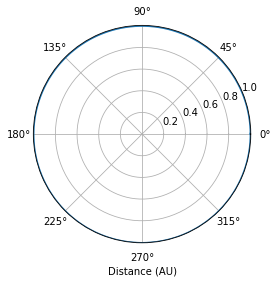

In [3]:
    # non-elliptical
    input_dict = {
        'r0': 1,
        'v0': 2*np.pi,
        'nStep': 1100,
        'tau': .001,
        'NumericalMethod': 2
        }
    print('non-elliptical')
    rplot, thplot, aphelion,perihelion,kinetic,potential = orbit(input_dict, calc_info=True)
    


________________
elliptical
Numerical Period: 0.43300000000000033
Theoretical Period: 0.4319593977248311

Numerical Semi-major axis: 0.5715996035490931
Theory Semi-major axis (calc with Kepler's 3rd law, using numerical period'): 0.5714285714285714
The similarity in computed vs. theory confirms Kepler's 3rd law (in this case)

Numerical eccentricity: 0.749474554592306
Theoretical eccentricity: 0.9258200997725515

Numerical Perihelion Distance: 0.1431938102404922
-----
Part c
time average kinetic energy: 34.323615149017584
- (1/2) * time average potential energy: 34.42743678134831


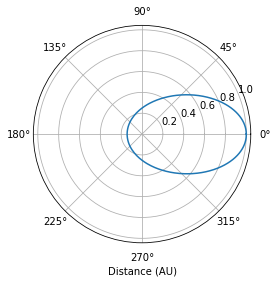

In [4]:
    # elliptical
    input_dict = {
        'r0': 1,
        'v0': 1*np.pi,
        'nStep': 3000,
        'tau': .001,
        'NumericalMethod': 2
        }
    print('________________\nelliptical')
    rplot, thplot, aphelion,perihelion,kinetic,potential= orbit(input_dict, calc_info=True)